#PART A — SoH MODELING

Imports & Load Feature Dataset

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# Load Phase 4 engineered dataset
df = pd.read_csv("phase4_features.csv")

print("Rows:", len(df))
print("Columns:", len(df.columns))


Rows: 1515717
Columns: 47


Prepare Target & Features

In [8]:
drop_soh = [
    "device_id",
    "timestamp",
    "event",
    "source",
    "soh",
    "cycle_count"  # dropped for generalisation
]

X_soh = df.drop(columns=drop_soh)
y_soh = df["soh"]
groups = df["device_id"]

print("SoH feature count:", X_soh.shape[1])


SoH feature count: 41


Define Strong but Generalised Model

In [9]:
soh_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("xgb", XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        min_child_weight=20,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1.0,
        reg_lambda=2.0,
        gamma=0.5,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ))
])


Strict GroupShuffleSplit Validation

In [10]:
gss = GroupShuffleSplit(n_splits=5, test_size=0.25, random_state=42)

r2_scores = []
mae_scores = []

for train_idx, test_idx in gss.split(X_soh, y_soh, groups):

    X_train, X_test = X_soh.iloc[train_idx], X_soh.iloc[test_idx]
    y_train, y_test = y_soh.iloc[train_idx], y_soh.iloc[test_idx]

    soh_model.fit(X_train, y_train)
    preds = soh_model.predict(X_test)

    r2_scores.append(r2_score(y_test, preds))
    mae_scores.append(mean_absolute_error(y_test, preds))

print("\nSoH Model Performance")
print("R² scores:", r2_scores)
print("MAE scores:", mae_scores)
print("Average R² :", np.mean(r2_scores))
print("Average MAE:", np.mean(mae_scores))



SoH Model Performance
R² scores: [0.9546474537366365, 0.9777391245795068, 0.9258045152306705, 0.9708155772733381, 0.9719176269202063]
MAE scores: [0.00997575345480508, 0.008082578843383325, 0.015247188577297422, 0.009191619637377909, 0.007298809018941384]
Average R² : 0.9601848595480718
Average MAE: 0.009959189906361025


Train Final Model

In [11]:
soh_model.fit(X_soh, y_soh)
joblib.dump(soh_model, "soh_model.pkl")

print("SoH model saved as soh_model.pkl")


SoH model saved as soh_model.pkl


VISUALISATIONS

Actual vs Predicted

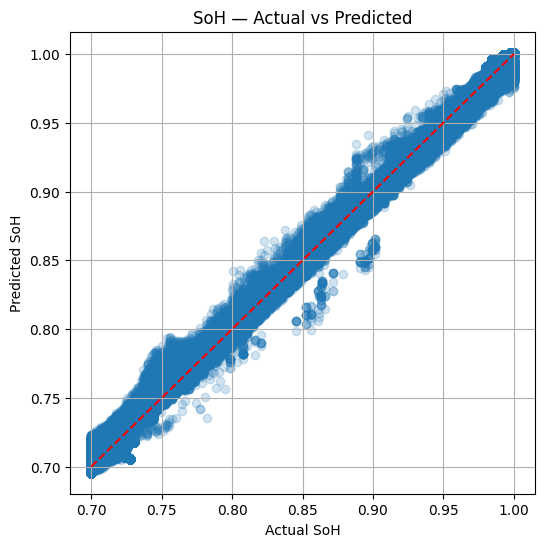

In [12]:
preds_full = soh_model.predict(X_soh)

plt.figure(figsize=(6,6))
plt.scatter(y_soh, preds_full, alpha=0.2)
plt.plot([y_soh.min(), y_soh.max()],
         [y_soh.min(), y_soh.max()],
         "r--")

plt.title("SoH — Actual vs Predicted")
plt.xlabel("Actual SoH")
plt.ylabel("Predicted SoH")
plt.grid(True)
plt.show()


Residual Distribution

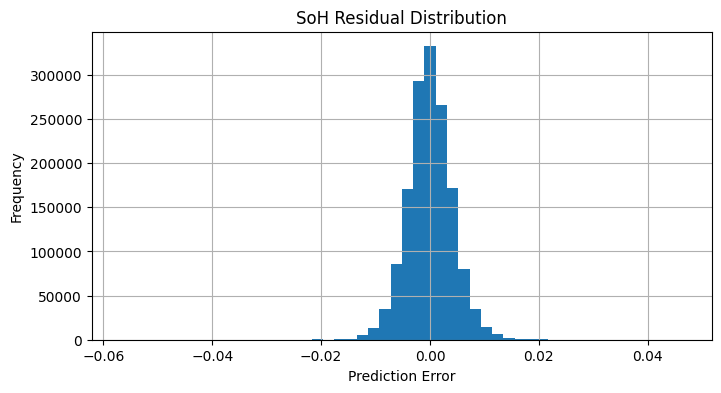

In [13]:
residuals = preds_full - y_soh

plt.figure(figsize=(8,4))
plt.hist(residuals, bins=50)
plt.title("SoH Residual Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


Feature Importance

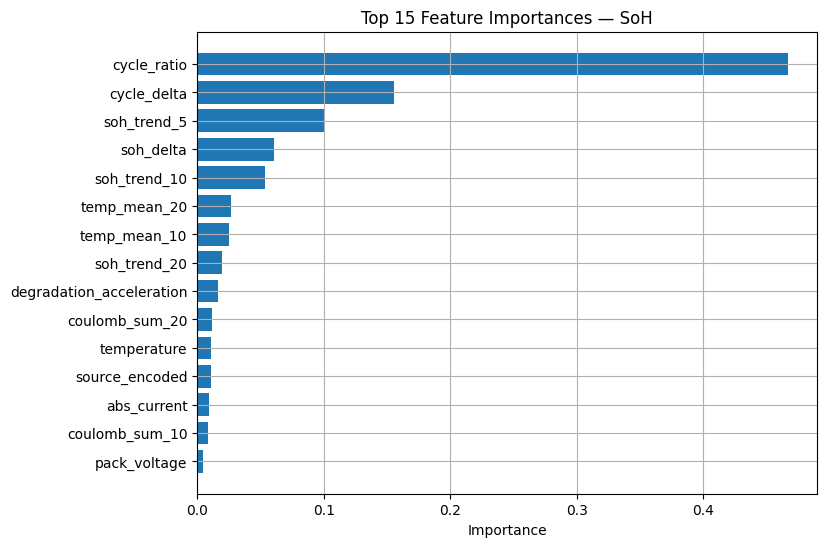

In [14]:
xgb_model = soh_model.named_steps["xgb"]
importances = xgb_model.feature_importances_
feature_names = X_soh.columns

indices = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(8,6))
plt.barh(
    [feature_names[i] for i in indices][::-1],
    importances[indices][::-1]
)

plt.title("Top 15 Feature Importances — SoH")
plt.xlabel("Importance")
plt.grid(True)
plt.show()


#PART B —RUL MODELING

Compute EOL Cycle (SoH ≤ 0.7)

In [23]:
EOL_THRESHOLD = 0.7

eol_cycles = {}

for device in df["device_id"].unique():

    device_df = df[df["device_id"] == device].sort_values("cycle_count")

    below_threshold = device_df[device_df["soh"] <= EOL_THRESHOLD]

    if len(below_threshold) > 0:
        eol_cycle = below_threshold["cycle_count"].iloc[0]
    else:
        # If never reaches threshold, use max cycle
        eol_cycle = device_df["cycle_count"].max()

    eol_cycles[device] = eol_cycle

print("EOL cycles per device:")
print(eol_cycles)


EOL cycles per device:
{'EV_RICK_01': np.int64(149), 'EV_SCOOT_01': np.int64(171), 'EV_TAXI_01': np.int64(194), 'NASA_B0005': np.int64(615), 'NASA_B0043': np.int64(274), 'NASA_B0045': np.int64(182), 'NASA_B0049': np.int64(60), 'NASA_B0054': np.int64(252)}


Create RUL Target Based on Threshold

In [24]:
df["EOL_cycle"] = df["device_id"].map(eol_cycles)

df["RUL_raw"] = df["EOL_cycle"] - df["cycle_count"]

# Prevent negative values
df["RUL_raw"] = df["RUL_raw"].clip(lower=0)

# Normalize
df["RUL_ratio"] = df["RUL_raw"] / df["EOL_cycle"]

print(df[["device_id","cycle_count","soh","RUL_raw"]].head())


    device_id  cycle_count  soh  RUL_raw
0  EV_RICK_01            0  1.0      149
1  EV_RICK_01            0  1.0      149
2  EV_RICK_01            0  1.0      149
3  EV_RICK_01            0  1.0      149
4  EV_RICK_01            0  1.0      149


Prepare RUL Features

In [25]:
drop_cols = [
    "device_id",
    "timestamp",
    "event",
    "source",
    "soh",
    "RUL_raw",
    "RUL_ratio",
    "EOL_cycle"
]

X_rul = df.drop(columns=drop_cols)
y_rul = df["RUL_ratio"]
groups = df["device_id"]

print("Feature count:", X_rul.shape[1])


Feature count: 43


Define RUL Model

In [26]:
rul_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("xgb", XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        min_child_weight=15,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1.0,
        reg_lambda=2.0,
        gamma=0.3,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ))
])


Validate RUL Model

In [27]:
gss = GroupShuffleSplit(n_splits=5, test_size=0.25, random_state=42)

r2_scores = []
mae_scores = []

for train_idx, test_idx in gss.split(X_rul, y_rul, groups):

    X_train, X_test = X_rul.iloc[train_idx], X_rul.iloc[test_idx]
    y_train, y_test = y_rul.iloc[train_idx], y_rul.iloc[test_idx]

    rul_model.fit(X_train, y_train)
    preds = rul_model.predict(X_test)

    r2_scores.append(r2_score(y_test, preds))
    mae_scores.append(mean_absolute_error(y_test, preds))

print("\n=== SoH-Threshold RUL Model Performance ===")
print("R² scores:", r2_scores)
print("MAE scores:", mae_scores)
print("Average R² :", np.mean(r2_scores))
print("Average MAE:", np.mean(mae_scores))



=== SoH-Threshold RUL Model Performance ===
R² scores: [0.981005850606214, 0.9945219152942281, 0.9592009807714871, 0.9736902314633533, 0.9962458870513631]
MAE scores: [0.03238285653126631, 0.016488717358115246, 0.052450212476611566, 0.03997015776256563, 0.009117896635880784]
Average R² : 0.9809329730373293
Average MAE: 0.030081968152887904


Train Final RUL Model & Save

In [28]:
rul_model.fit(X_rul, y_rul)
joblib.dump(rul_model, "rul_model.pkl")

print("Threshold-based RUL model saved as rul_model.pkl")


Threshold-based RUL model saved as rul_model.pkl


In [30]:
# Generate predictions using trained RUL model
df["predicted_RUL_ratio"] = rul_model.predict(X_rul)

# Convert to cycle units
max_cycle = df.groupby("device_id")["cycle_count"].transform("max")
df["predicted_RUL_cycles"] = df["predicted_RUL_ratio"] * max_cycle

print("Prediction columns created successfully.")
print(df[["RUL_ratio", "predicted_RUL_ratio"]].head())


Prediction columns created successfully.
   RUL_ratio  predicted_RUL_ratio
0        1.0             0.983481
1        1.0             0.983481
2        1.0             0.983083
3        1.0             0.983083
4        1.0             0.983481


RUL Visualisations

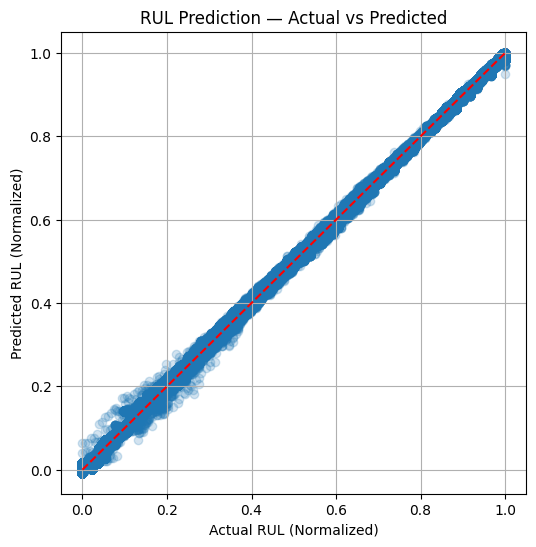

In [31]:
plt.figure(figsize=(6,6))

plt.scatter(
    df["RUL_ratio"],
    df["predicted_RUL_ratio"],
    alpha=0.2
)

plt.plot([0,1],[0,1], "r--")

plt.xlabel("Actual RUL (Normalized)")
plt.ylabel("Predicted RUL (Normalized)")
plt.title("RUL Prediction — Actual vs Predicted")
plt.grid(True)
plt.show()


Residual Distribution

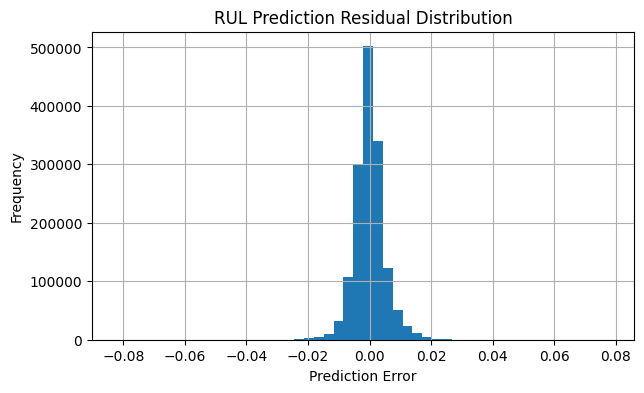

In [32]:
residuals = df["predicted_RUL_ratio"] - df["RUL_ratio"]

plt.figure(figsize=(7,4))
plt.hist(residuals, bins=50)

plt.title("RUL Prediction Residual Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


Residuals vs Cycle Count

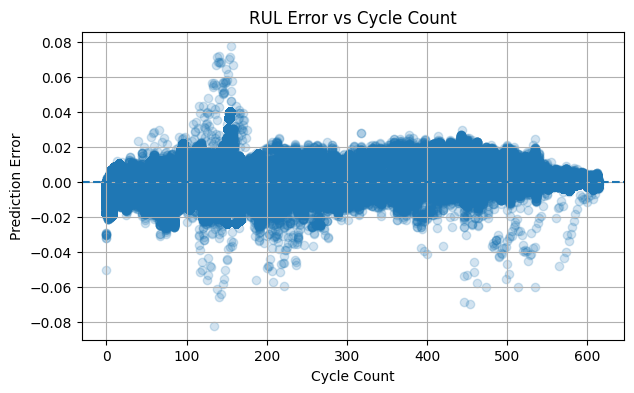

In [33]:
plt.figure(figsize=(7,4))

plt.scatter(
    df["cycle_count"],
    residuals,
    alpha=0.2
)

plt.axhline(0, linestyle="--")

plt.xlabel("Cycle Count")
plt.ylabel("Prediction Error")
plt.title("RUL Error vs Cycle Count")
plt.grid(True)
plt.show()


Actual vs Predicted (Cycle Units)

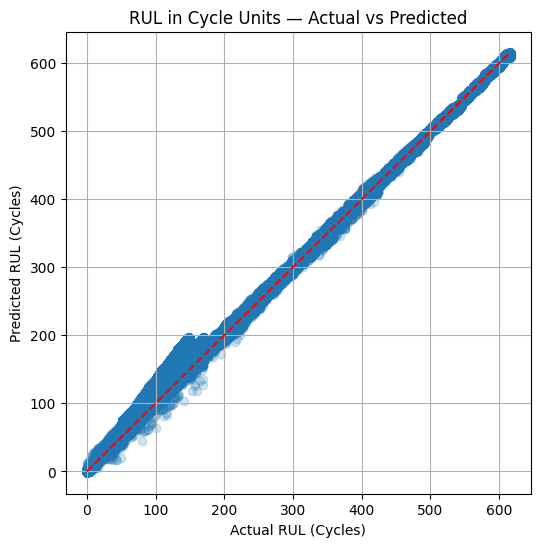

In [34]:
plt.figure(figsize=(6,6))

plt.scatter(
    df["RUL_raw"],
    df["predicted_RUL_cycles"],
    alpha=0.2
)

min_val = df["RUL_raw"].min()
max_val = df["RUL_raw"].max()

plt.plot([min_val, max_val],
         [min_val, max_val],
         "r--")

plt.xlabel("Actual RUL (Cycles)")
plt.ylabel("Predicted RUL (Cycles)")
plt.title("RUL in Cycle Units — Actual vs Predicted")
plt.grid(True)
plt.show()


RUL Curve Per Device

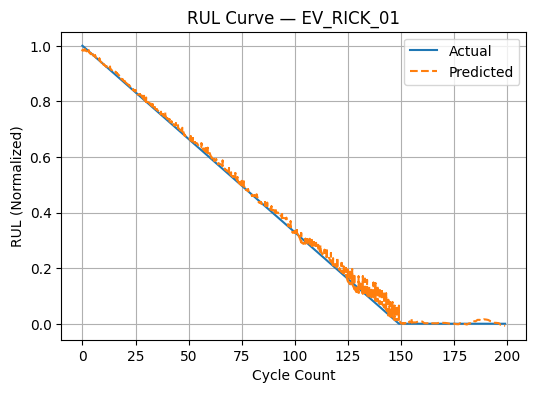

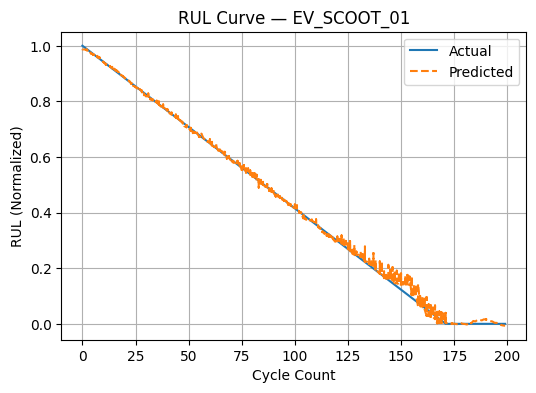

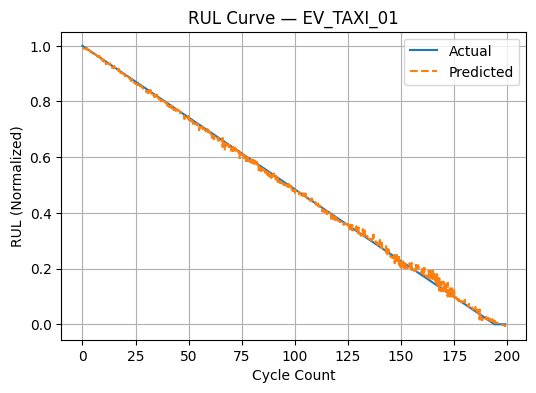

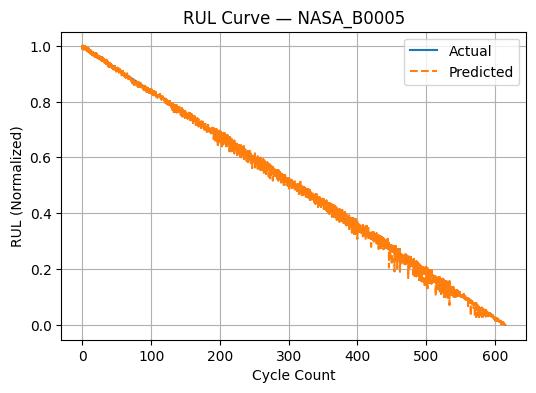

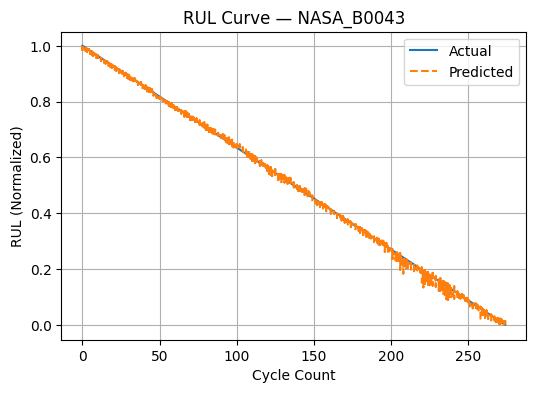

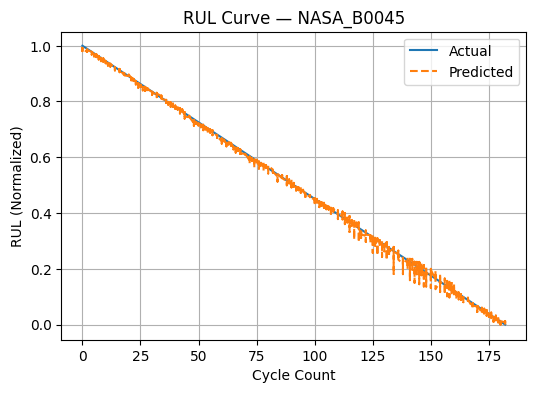

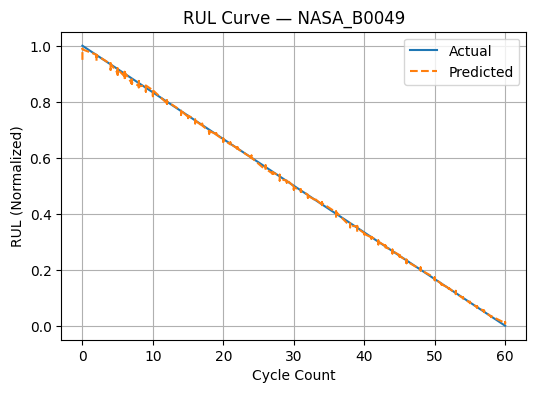

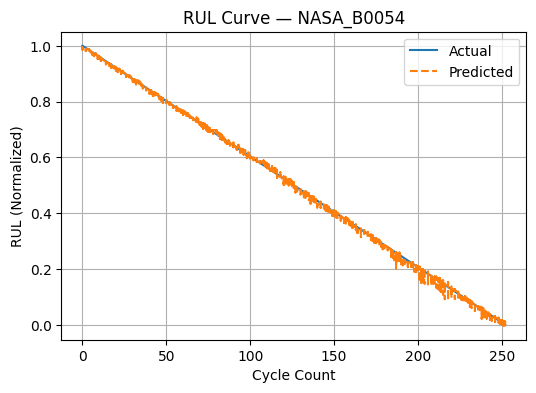

In [35]:
for device in df["device_id"].unique():

    device_df = df[df["device_id"] == device]
    device_df = device_df.sort_values("cycle_count")

    plt.figure(figsize=(6,4))

    plt.plot(
        device_df["cycle_count"],
        device_df["RUL_ratio"],
        label="Actual"
    )

    plt.plot(
        device_df["cycle_count"],
        device_df["predicted_RUL_ratio"],
        label="Predicted",
        linestyle="--"
    )

    plt.xlabel("Cycle Count")
    plt.ylabel("RUL (Normalized)")
    plt.title(f"RUL Curve — {device}")
    plt.legend()
    plt.grid(True)
    plt.show()


Feature Importance (RUL Model)

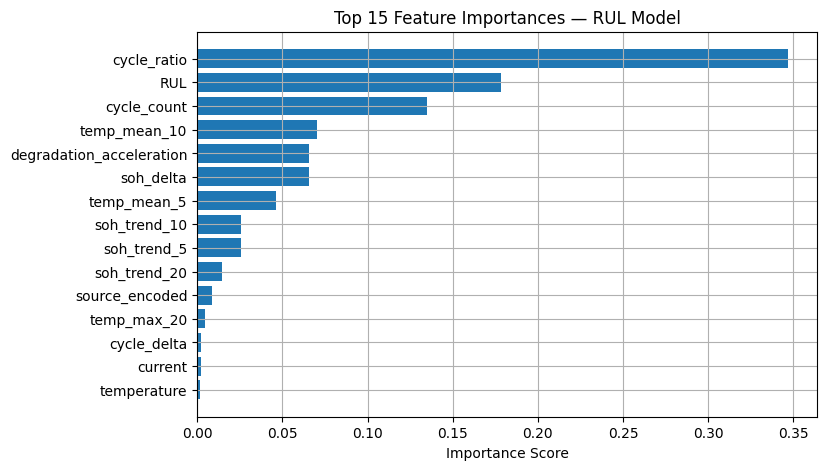

In [36]:
xgb_model = rul_model.named_steps["xgb"]
importances = xgb_model.feature_importances_
feature_names = X_rul.columns

idx = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(8,5))

plt.barh(
    [feature_names[i] for i in idx][::-1],
    importances[idx][::-1]
)

plt.xlabel("Importance Score")
plt.title("Top 15 Feature Importances — RUL Model")
plt.grid(True)
plt.show()


Fold Performance Visualization

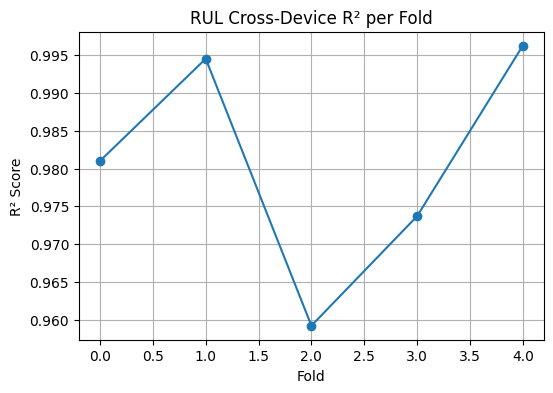

In [37]:
plt.figure(figsize=(6,4))

plt.plot(r2_scores, marker="o")
plt.title("RUL Cross-Device R² per Fold")
plt.xlabel("Fold")
plt.ylabel("R² Score")
plt.grid(True)
plt.show()
